### D804 Exam Success Prediction Model

## Environment/System Checks

In [1]:
import sys
import platform
import os
from datetime import datetime

import matplotlib

print("Run timestamp:", datetime.now().isoformat(timespec="seconds"))
print("Python version:", sys.version)
print("Platform:", platform.platform())
print("Working directory:", os.getcwd())

Run timestamp: 2025-12-31T11:15:26
Python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Platform: Windows-10-10.0.26200-SP0
Working directory: C:\Users\Robert\Desktop\d804-advanced-ai-for-computer-scientists\D804_PA_Optimization_Exam_Success_Prediction\notebooks


In [2]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)

NumPy: 2.4.0
Pandas: 2.3.3


## Load Raw Data

In [3]:
DATA_PATH = "../data/exam_score_prediction_raw.csv"

df_raw = pd.read_csv(DATA_PATH)

print("Shape:", df_raw.shape)
df_raw.head()

Shape: (20000, 13)


,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


## Data Audit

In [4]:
df_raw.info()

missing = df_raw.isna().sum().sort_values(ascending=False)
missing[missing > 0]

dup_count = df_raw.duplicated().sum()
print("Duplicate rows:", dup_count)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB
Duplicate rows: 0


## Exam Score Column Details

In [5]:
df_raw.columns

df_raw.describe(include="all").T.head(20)

SCORE_COL = "exam_score"

df_raw[SCORE_COL].describe()

count    20000.000000
mean        62.513225
std         18.908491
min         19.599000
25%         48.800000
50%         62.600000
75%         76.300000
max        100.000000
Name: exam_score, dtype: float64

## Create Pass/Not Pass Classification Target

In [6]:
PASS_THRESHOLD = 60

df = df_raw.copy()
df["pass_label"] = (df[SCORE_COL] >= PASS_THRESHOLD).astype(int)

print(df["pass_label"].value_counts())
print(df["pass_label"].value_counts(normalize=True).round(3))

pass_label
1    11047
0     8953
Name: count, dtype: int64
pass_label
1    0.552
0    0.448
Name: proportion, dtype: float64


## Select Features

In [7]:
FEATURES = [
    "gender",
    "study_hours",
    "sleep_hours",
    "sleep_quality"
]

X = df[FEATURES].copy()
y = df["pass_label"].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)
X.head()

X shape: (20000, 4)
y shape: (20000,)


,gender,study_hours,sleep_hours,sleep_quality
0,male,2.78,7.4,poor
1,other,3.37,4.6,average
2,male,7.88,8.5,poor
3,other,0.67,5.8,average
4,female,0.89,9.8,poor


## Preprocessing Categorical/Numeric Columns

In [8]:
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

print("Categorical:", cat_cols)
print("Numeric:", num_cols)

Categorical: ['gender', 'sleep_quality']
Numeric: ['study_hours', 'sleep_hours']


## Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (16000, 4) Test: (4000, 4)


## Preprocessing Pipeline

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [11]:
# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

## Define Random Forest Advanced Model

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

## Build Full Modeling Pipeline

In [13]:
model = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("classifier", rf_model)
    ]
)

## Train the Model

In [14]:
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transform

## Model Evaluation

### Predictions

In [15]:
y_pred = model.predict(X_test)

### Classification Report

In [16]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.724     0.736     0.730      1791
           1      0.783     0.772     0.777      2209

    accuracy                          0.756      4000
   macro avg      0.753     0.754     0.754      4000
weighted avg      0.756     0.756     0.756      4000



### Confusion Matrix

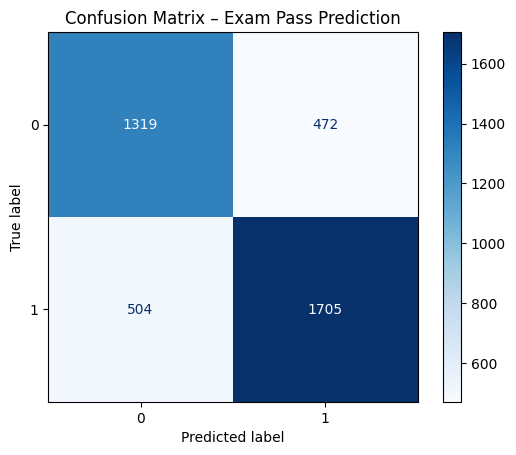

In [17]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Exam Pass Prediction")
plt.show()

## Feature Importance

In [18]:
# Extract feature names after one-hot encoding
feature_names = (
    model.named_steps["preprocessing"]
    .get_feature_names_out()
)

importances = model.named_steps["classifier"].feature_importances_

feat_imp = (
    pd.Series(importances, index=feature_names)
    .sort_values(ascending=False)
)

feat_imp.head(10)

num__study_hours           0.758114
num__sleep_hours           0.202284
cat__sleep_quality_good    0.013883
cat__sleep_quality_poor    0.013721
cat__gender_male           0.006132
cat__gender_other          0.005866
dtype: float64

## Save Model

In [19]:
import joblib

MODEL_PATH = "../data/model_exam_success_rf.joblib"
joblib.dump(model, MODEL_PATH)

print("Model saved to:", MODEL_PATH)

Model saved to: ../data/model_exam_success_rf.joblib


## Save model as CSV for GitLab

In [20]:
import pandas as pd

# Get predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Build a viewable table
results = X_test.copy()
results["actual_pass"] = y_test.values
results["pred_pass"] = y_pred
results["pred_proba_pass"] = y_proba

# Save CSV
results_path = "../data/exam_success_model_results.csv"
results.to_csv(results_path, index=False)

results.head()

,gender,study_hours,sleep_hours,sleep_quality,actual_pass,pred_pass,pred_proba_pass
8900,other,5.43,7.6,poor,1,1,0.825000
15743,other,7.41,6.9,average,1,1,1.000000
18066,female,2.73,9.0,good,0,1,0.730000
2992,other,6.06,7.0,poor,1,1,0.903092
11640,male,4.50,7.3,poor,0,0,0.020000


# Part J: Optimization Section

## Load Model 1 from Results

In [21]:
import pandas as pd

RESULTS_PATH = "../data/exam_success_model_results.csv"

df_results = pd.read_csv(RESULTS_PATH)

print("Shape:", df_results.shape)
df_results.head()

Shape: (4000, 7)


,gender,study_hours,sleep_hours,sleep_quality,actual_pass,pred_pass,pred_proba_pass
0,other,5.43,7.6,poor,1,1,0.825000
1,other,7.41,6.9,average,1,1,1.000000
2,female,2.73,9.0,good,0,1,0.730000
3,other,6.06,7.0,poor,1,1,0.903092
4,male,4.50,7.3,poor,0,0,0.020000


## Reconstruct Core Performance Metrics

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = df_results["actual_pass"]
y_pred = df_results["pred_pass"]

print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.724     0.736     0.730      1791
           1      0.783     0.772     0.777      2209

    accuracy                          0.756      4000
   macro avg      0.753     0.754     0.754      4000
weighted avg      0.756     0.756     0.756      4000



## Baseline Confusion Matrix

In [23]:
confusion_matrix(y_true, y_pred)

array([[1319,  472],
       [ 504, 1705]])

## Optimization Objective

The goal of optimization is to improve balanced performance across classes,
with emphasis on recall for the passing class while maintaining overall accuracy.

## Selected Optimization Strategy

Hyperparameter tuning will be applied to control model complexity
and reduce overfitting, focusing on tree depth and minimum samples per leaf.

## Load Raw Data and Rebuild Baseline Pipeline

In [24]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [25]:
RAW_PATH = "../data/exam_score_prediction_raw.csv"  # adjust if your raw file name differs

df_raw = pd.read_csv(RAW_PATH)
print("Raw shape:", df_raw.shape)
df_raw.head()

Raw shape: (20000, 13)


,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


## Recreate Features/Target and Split Data

In [26]:
PASS_THRESHOLD = 60

df = df_raw.copy()
df["pass_label"] = (df["exam_score"] >= PASS_THRESHOLD).astype(int)

FEATURES = ["gender", "study_hours", "sleep_hours", "sleep_quality"]
X = df[FEATURES].copy()
y = df["pass_label"].copy()

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

print("X shape:", X.shape)
print("Class balance:\n", y.value_counts(normalize=True).round(3))
print("Categorical:", cat_cols)
print("Numeric:", num_cols)

X shape: (20000, 4)
Class balance:
 pass_label
1    0.552
0    0.448
Name: proportion, dtype: float64
Categorical: ['gender', 'sleep_quality']
Numeric: ['study_hours', 'sleep_hours']


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Train Baseline Model (Pre-Optimization)

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

baseline_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

baseline_model = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("classifier", baseline_rf)
    ]
)

baseline_model.fit(X_train, y_train)

baseline_pred = baseline_model.predict(X_test)

print("Baseline classification report:")
print(classification_report(y_test, baseline_pred, digits=3))
print("Baseline confusion matrix:")
print(confusion_matrix(y_test, baseline_pred))

Baseline classification report:
              precision    recall  f1-score   support

           0      0.724     0.736     0.730      1791
           1      0.783     0.772     0.777      2209

    accuracy                          0.756      4000
   macro avg      0.753     0.754     0.754      4000
weighted avg      0.756     0.756     0.756      4000

Baseline confusion matrix:
[[1319  472]
 [ 504 1705]]


## Optimization 1: Reduce Model Complexity

In [29]:
optimized_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,          # controlled depth
    min_samples_leaf=5,    # smoother leaves
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

optimized_model = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("classifier", optimized_rf)
    ]
)

optimized_model.fit(X_train, y_train)

opt_pred = optimized_model.predict(X_test)

print("Optimized classification report:")
print(classification_report(y_test, opt_pred, digits=3))
print("Optimized confusion matrix:")
print(confusion_matrix(y_test, opt_pred))

Optimized classification report:
              precision    recall  f1-score   support

           0      0.745     0.800     0.771      1791
           1      0.827     0.778     0.802      2209

    accuracy                          0.788      4000
   macro avg      0.786     0.789     0.787      4000
weighted avg      0.790     0.788     0.788      4000

Optimized confusion matrix:
[[1432  359]
 [ 490 1719]]


## Compare Baseline and Optimization Data

In [30]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def summarize(y_true, y_hat):
    return {
        "accuracy": accuracy_score(y_true, y_hat),
        "precision": precision_score(y_true, y_hat),
        "recall": recall_score(y_true, y_hat),
        "f1": f1_score(y_true, y_hat)
    }

baseline_summary = summarize(y_test, baseline_pred)
opt_summary = summarize(y_test, opt_pred)

summary_df = pd.DataFrame([baseline_summary, opt_summary], index=["baseline", "optimized"]).round(4)
summary_df

,accuracy,precision,recall,f1
baseline,0.7560,0.7832,0.7718,0.7775
optimized,0.7877,0.8272,0.7782,0.8020
